# ADAmax Milestone 3

In this notebook, we present the details behind the data story.

Structure of the respository:


 - data/
      - Imdb/
      - MovieSummaries/
 - src/
      - initial_analysis.ipynb
      - helpers.py
      - preprocess.py

## The Big Flop

### Initial preprocess (only run once)

The preprocess works like this:
  - One of the movie has a released date in 1010 and that is not possible. After checking on the web, the released date was in 2010.
  - To take into account the inflation, we create the features **adj_budjet**, **adj_revenue**, ... that are the the values of budget and revenue ajusted with the inflation. 

In [1]:
# from preprocess import preprocess

# preprocess()

### Getting the data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pickle
import ipywidgets as widgets
import geopandas

from tqdm import tqdm
from scipy.stats import bootstrap, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from helpers import *
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")

In the CMU dataset, we have basic features like `revenue`, `movie titles`, `genres`, `countries` etc. In the IMDb dataset, there are a lot of additional features like `budget`, `producer` `information`, and `user ratings`.

Initially, there is no common key (column to merge) for the two datasets. Fortunately, for almost all of the Freebase IDs, we were able to find corresponding IMDb IDs.

In this notebook, we only consider the merged dataset (and any of its derivations).

There are features with the same name in both datasets (runtime and revenue), but they are not identical in values. For example, the movie runtimes can be different between the two datasets.

In [3]:
# Get the movie dataframe (merged from CMU and IMDb)
df_movies = get_movies()
df_movies = df_movies[df_movies["vote_count"] > 9]
display(df_movies.head(3))
display(df_movies.describe())
df_movies.columns


,wiki_id,freebase_id,name,box_office_revenue,runtime_x,languages,countries,adj_revenue_x,imdb_id,adult,...,title,video,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,genres,year,release_date
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",2.143713e+07,tt0228333,False,...,Ghosts of Mars,False,4.8,299.0,2.143713e+07,4.284111e+07,-2.140398e+07,"{Adventure, Thriller, Action, Science Fiction,...",2001.0,2001-08-24
1,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",NaN,tt0094320,False,...,White of the Eye,False,5.7,15.0,0.000000e+00,0.000000e+00,0.000000e+00,"{Psychological thriller, Thriller, Horror, Ero...",1987.0,1987-01-01
3,171005,/m/016ywb,Henry V,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}",2.220446e+07,tt0097499,False,...,Henry V,False,7.4,73.0,0.000000e+00,1.966718e+07,-1.966718e+07,"{Drama, History, War film, Costume drama, War,...",1989.0,1989-11-08


,wiki_id,box_office_revenue,runtime_x,adj_revenue_x,revenue,runtime_y,vote_average,vote_count,adj_revenue_y,adj_budget,adj_profit,year
count,1.529000e+04,6.018000e+03,14708.000000,6.003000e+03,1.529000e+04,15289.000000,15290.000000,15290.000000,1.524000e+04,1.524000e+04,1.524000e+04,15041.000000
mean,9.908860e+06,5.926690e+07,102.170491,1.119192e+08,2.392706e+07,101.702793,6.200922,221.150883,4.301764e+07,1.448224e+07,2.853541e+07,1990.473506
std,1.059525e+07,1.213477e+08,28.286347,2.629453e+08,8.750213e+07,28.942026,0.964606,681.791034,1.707046e+08,3.522743e+07,1.547415e+08,21.154214
min,3.217000e+03,1.067000e+04,0.000000,1.325921e+04,0.000000e+00,0.000000,0.000000,10.000000,0.000000e+00,0.000000e+00,-8.363272e+08,1890.000000
25%,1.683457e+06,4.555898e+06,90.000000,1.109502e+07,0.000000e+00,90.000000,5.600000,17.000000,0.000000e+00,0.000000e+00,0.000000e+00,1980.000000
50%,4.966709e+06,1.755057e+07,99.000000,3.703290e+07,0.000000e+00,99.000000,6.300000,35.000000,0.000000e+00,0.000000e+00,0.000000e+00,1998.000000
75%,1.627772e+07,5.785524e+07,112.000000,1.103739e+08,5.027906e+06,112.000000,6.900000,120.000000,9.844165e+06,1.066811e+07,7.063828e+04,2007.000000
max,3.737388e+07,2.782275e+09,1003.000000,7.828022e+09,2.787965e+09,705.000000,9.200000,14075.000000,7.801138e+09,8.363272e+08,7.723161e+09,2016.000000


Index(['wiki_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime_x',
       'languages', 'countries', 'adj_revenue_x', 'imdb_id', 'adult',
       'belongs_to_collection', 'budget', 'homepage', 'id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'production_companies', 'production_countries',
       'revenue', 'runtime_y', 'spoken_languages', 'status', 'tagline',
       'title', 'video', 'vote_average', 'vote_count', 'adj_revenue_y',
       'adj_budget', 'adj_profit', 'genres', 'year', 'release_date'],
      dtype='object')

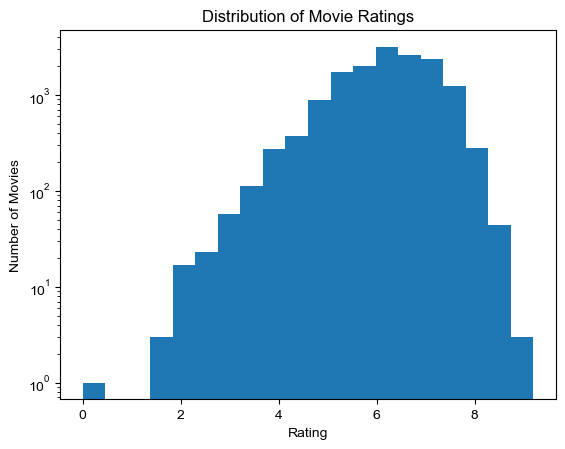

In [4]:
# Plot a histogram of the movie ratings from the IMDb dataset.
plt.hist(df_movies['vote_average'], bins=20)
plt.style.use('seaborn')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Movies')
plt.yscale('log')
plt.show()

#### Process the genres

We reduced the number of genre to 41 grouping them into "main genres" and keeping only the most interesting ones.

In [5]:
dict_similar = {
    "Porn": ["Pornographic movie", "Pornography", "Softcore Porn", "Adult", "Sexploitation", "Erotica", "homoeroticism"], 
    "Action": ["Action/adventure", "ninja movie", "epic", "auto racing", "martial arts film", "race movie", "samurai cinema"],
    "Adventure": ["Adventure", "travel"],
    "Animals": ["Animal Picture"],
    "Anime": [],
    "Alien Film": ["Alien invasion"],
    "Animation": ["Animated cartoon"],
    "Beach Film": ["Beach Party film"],
    "Biographical film": ["Biography", "Biopic [feature]"],
    "Buddy film": ["Buddy Picture", "Buddy cop"],
    "Coming of age": ["Coming-of-age film"],
    "Comedy": ["Humour", "Tragicomedy", "Ealing Comedies", "Comdedy", "Adventure Comedy", "Commedy of manners", "Workplace comedy", "comedy-drama"], 
    "Crime": ['crime', 'crime fiction', 'crime thriller', "master criminal films", "detective"],
    "Documentary": ["Political Documetary", "Docudrama", "Historical Documentaries", "Rockumentary", "media studies", "media satire"], 
    "Drama": ["Melodrama", "Tragedy", "Tragicomedy", "Docudrama", "Family drama", "Comedy-drama", 'illnesses & disabilities'], 
    "Family": ["Family Film"],
    "Fiction": ["fairy tail", "fictional film", "medical fiction", "mythological fantasy", "sci fi pictures", 'sci fi pictures original films', "sword and sorcery films", "sword and sandal", "time travel", "supernatural"],
    "Gross out": ["Gross-out Film"],
    "Historical": ["history", "Biographical", "British History", "British Empire Film", "British new wave", "Historical Epic", "Cold War", "Historical Documentaries"],
    "Monster": ["Creature Movie", "Monster Movie", "Creature"],
    "Horror": ["Natural Horror film", "Sci-fi Horror", "road-horror"],
    "Indie": ["Indie"],
    "Language & Literature": ["& Literature"], 
    "LGBT": ["New Queer Cinema", "Gay", "Homoeroticism"],
    "Old movies": ["Silent film", "black-and-white"],
    "Parody": [],
    "Political cinema": ["Political Documentary"],
    "Prison": ["Prison film", "Women in prison film"],
    "Master Criminal Films": ["Heist", "Gangster Film"],
    "Music": ["Concert film", "Film-Opera", "Operetta", "Punk rock", "Rockumentary", "Space opera", "Singing cowboy", "Hip hop movies", "Breakdance", "Dance", "musical"],
    "For children": ["Children's film", "children's", "children's entertainment", "children's fantasy", "children's/family"],
    "Religious Film": ["Christian film", "Cult"],
    "Romance": ["Romance film", "romantic fantasy"],
    "Sport": ["baseball", "boxing", "sports"],
    "Super hero": ["superhero movie", "superhero"],
    "Social issues": ["Social problem film"], 
    "Television Movie": ["TV Movie"],
    "Thriller": ["erotic thriller", "film à clef", "mystery", "suspense"],
    "War film": ["war", "War effort", "The Netherlands in World War II", "Gulf War", "Combat Films", "movies about gladiators", "anti-war", "anti-war film", "nuclear warfare", "foreign legion"],
    "Western": ["Singing cowboy", "Westerns", "B-Western", "Epic Western", "Spaghetti Western"],
    "World cinema": ["Chinese Movies", "Japanese Movies", "Latino", "americana", "bengali cinema", "filipino movies"],
    "Zombie": ["Zombie film", "Z-movie", "z movie"]
}

dict_similar_rev = dict()
for key, value in dict_similar.items():
    key = key.lower()
    for v in value:
        v = v.lower()
        dict_similar_rev[v] = key
    dict_similar_rev[key] = key

def get_genre(set_genres):
    new_genres = set()
    for g in set_genres:
        g = g.lower()
        temp = True
        for s_g in g.split(" "):
            if s_g in dict_similar_rev.keys():
                new_genres.add(dict_similar_rev[s_g])
                temp = False
        if temp:
            if g in dict_similar_rev.keys():
                new_genres.add(dict_similar_rev[g])
            # else:
            #     new_genres.add(g)

    return new_genres

df_movies["genres"] = df_movies["genres"].apply(get_genre)

In [6]:
all_genres = set()

for genres in df_movies["genres"]:
    all_genres.update(genres)

print("We have in total", len(all_genres), "different genres")
print(sorted(list(all_genres)))

We have in total 42 different genres
['action', 'adventure', 'alien film', 'animals', 'animation', 'anime', 'beach film', 'biographical film', 'buddy film', 'comedy', 'coming of age', 'crime', 'documentary', 'drama', 'family', 'fiction', 'for children', 'gross out', 'historical', 'horror', 'indie', 'language & literature', 'lgbt', 'master criminal films', 'monster', 'music', 'old movies', 'parody', 'political cinema', 'porn', 'prison', 'religious film', 'romance', 'social issues', 'sport', 'super hero', 'television movie', 'thriller', 'war film', 'western', 'world cinema', 'zombie']


In [7]:
# Create a column for each genre
for genre in all_genres:
    df_movies[f"is_{genre}"] = df_movies["genres"].apply(lambda x: genre in x)

### General analysis

#### Top and worst genres of all time

In [8]:
# genre rating
genre_rates = dict()
for genre in all_genres:
    g_rates = df_movies[df_movies[f"is_{genre}"]]["vote_average"].values
    if len(g_rates) < 100:
        continue
    ci = bootstrap([g_rates], statistic=np.mean, n_resamples=1000).confidence_interval
    genre_rates[genre] = np.mean(g_rates), ci.low, ci.high, g_rates



In [9]:
print(genre_rates["animation"])

(6.529988974641677, 6.480346837563721, 6.583566790955809, array([6.7, 6.1, 5.4, 7.9, 6.7, 6.1, 6.8, 6.1, 6.7, 5.5, 6.6, 6.2, 6. ,
       7.8, 5.3, 6.8, 6.2, 7.2, 5.9, 7.7, 6.3, 4.9, 7.5, 6. , 6.7, 6.6,
       6.1, 7. , 7. , 6.2, 6.7, 7.8, 6.3, 7.7, 6.7, 6. , 7.7, 5.2, 4.9,
       8.2, 5.8, 5.8, 7. , 7.2, 6.3, 7.6, 7. , 7.6, 6.6, 6.3, 7.8, 6.9,
       6.2, 5.4, 5.3, 4.9, 6.9, 7.6, 5.5, 6.9, 7.2, 7.3, 7.4, 5.8, 6.4,
       6.2, 6.1, 6.3, 7.4, 6.9, 6.3, 7.6, 5.4, 6.1, 6.7, 6.2, 5.2, 8. ,
       6.7, 8.1, 4.8, 5.3, 6. , 5.6, 7.1, 7.8, 7.1, 7. , 7.9, 5.3, 6.9,
       5.2, 6.4, 6.7, 6. , 6.1, 7.2, 6.5, 7.7, 6.2, 6.3, 7.2, 7.5, 6.4,
       5.8, 7.1, 7.3, 6.2, 7.5, 7.8, 5.9, 6.4, 7.7, 6.6, 6.7, 6.9, 6.1,
       6.8, 7.9, 6.3, 7. , 7.6, 6.6, 4. , 6. , 6.6, 7.6, 6.6, 7.2, 6.7,
       7.1, 6.7, 6.9, 6. , 7.9, 5.8, 7.1, 7. , 6.5, 6.9, 8. , 8. , 6.2,
       7. , 6.8, 7. , 6.4, 7.3, 4.4, 6.4, 7.4, 6.7, 6.3, 6.2, 6.4, 5.9,
       5.7, 6.2, 7. , 6.6, 5.1, 5.8, 6.3, 4. , 6.3, 6.9, 7.6, 7.1, 5.4,
      

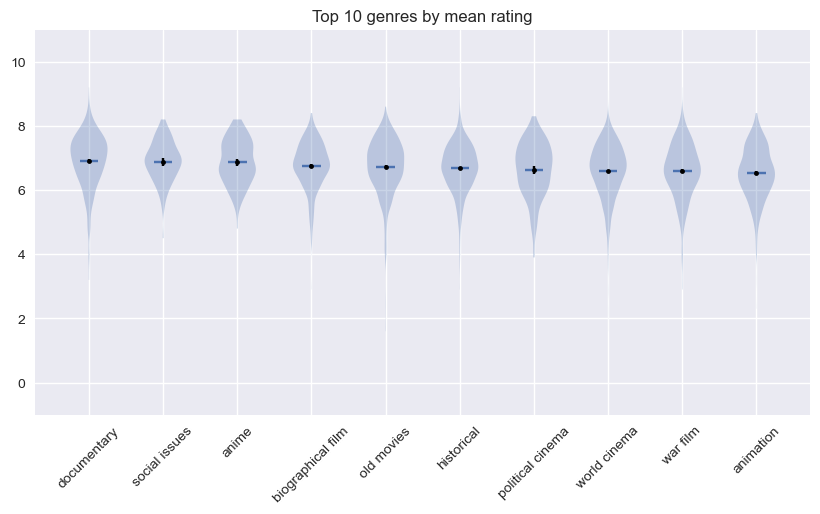

In [10]:
# Plot the top 10 genres
top10 = sorted(genre_rates.items(), key=lambda x: x[1][0], reverse=True)[:10]

plt.figure(figsize=(10, 5))
plt.violinplot([x[1][3] for x in top10], showmeans=True, showextrema=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in top10])
# plt.bar([x[0] for x in top10], [x[1][0] for x in top10])
plt.errorbar(list(range(1, 11)), [x[1][0] for x in top10], yerr=[[x[1][0]-x[1][1] for x in top10], [x[1][2]-x[1][0] for x in top10]], fmt='.', color='black')
plt.xticks(rotation=45)
plt.ylim(-1, 11)
plt.title("Top 10 genres by mean rating")
plt.show()


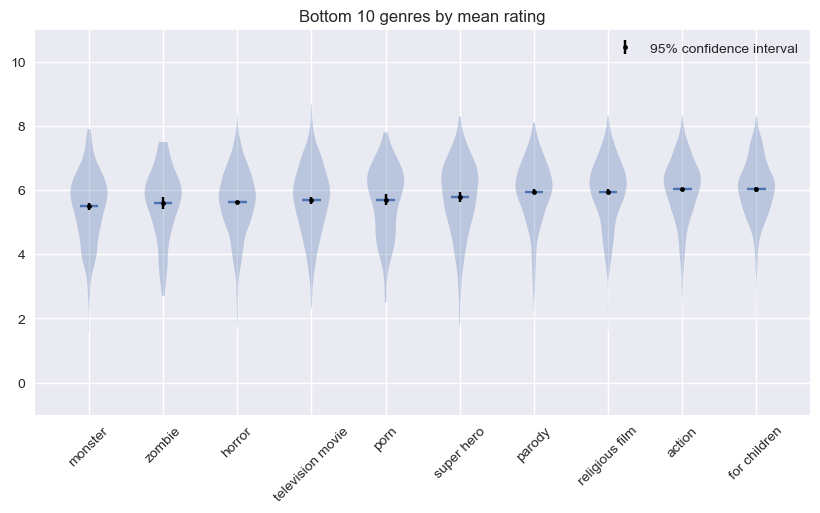

In [11]:
# Plot the bottom 10 genres
bottom10 = sorted(genre_rates.items(), key=lambda x: x[1][0], reverse=False)[:10]

plt.figure(figsize=(10, 5))
plt.violinplot([x[1][3] for x in bottom10], showmeans=True, showextrema=False)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in bottom10])
# plt.bar([x[0] for x in bottom10], [x[1][0] for x in bottom10], label="Average rating")
plt.errorbar(list(range(1, 11)), [x[1][0] for x in bottom10], yerr=[[x[1][0]-x[1][1] for x in bottom10], [x[1][2]-x[1][0] for x in bottom10]], fmt='.', color='black', label="95% confidence interval")
plt.xticks(rotation=45)
plt.ylim(-1, 11)
plt.title("Bottom 10 genres by mean rating")
plt.legend()
plt.show()


#### Evolution over time

Here is the code of a widget that helped us visualizing the evolution of most/worst popular genres over years. The widget shows the top 10 and bottom 10 genre over years.

Nevertheless we cannot play with this widget without running the code. As a compensation, here are some example of what we noticed.

In [12]:
# Genre rating by year
genre_rates_by_year = dict()
for year in tqdm(range(1900, 2020)):
    genre_rates_by_year[year] = dict()
    for genre in all_genres:
        g_rates = df_movies[(df_movies[f"is_{genre}"]) & (df_movies["year"] <= year)]["vote_average"].values
        if len(g_rates) < 100:
            continue
        ci = bootstrap([g_rates], statistic=np.mean, n_resamples=1000).confidence_interval
        genre_rates_by_year[year][genre] = np.mean(g_rates), ci.low, ci.high, g_rates

100%|██████████| 120/120 [01:24<00:00,  1.42it/s]


In [13]:
# Plot the top 10 genres by year
widget = widgets.IntSlider(min=1950, max=2019, step=1, value=1950)
def plot_top10_by_year(year):
    top10 = sorted(genre_rates_by_year[year].items(), key=lambda x: x[1][0], reverse=True)[:10]
    plt.figure(figsize=(10, 5))
    plt.bar([x[0] for x in top10], [x[1][0] for x in top10])
    # plt.violinplot([x[1][3] for x in top10], showmeans=True, showextrema=False)
    # plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], [x[0] for x in top10])
    plt.errorbar([x[0] for x in top10], [x[1][0] for x in top10], yerr=[[x[1][0]-x[1][1] for x in top10], [x[1][2]-x[1][0] for x in top10]], fmt='o', color='black')
    plt.xticks(rotation=45)
    plt.ylim(-1, 11)
    plt.title(f"Top 10 genres by average rating in {year}")
    plt.show()

widgets.interact(plot_top10_by_year, year=widget)


interactive(children=(IntSlider(value=1950, description='year', max=2019, min=1950), Output()), _dom_classes=(…

<function __main__.plot_top10_by_year(year)>

In [14]:
# Plot the bottom 10 genres by year
widget = widgets.IntSlider(min=1920, max=2013, step=1, value=2013, description="Year:")
def plot_genre_by_year(year):
    bottom10 = sorted(genre_rates_by_year[year].items(), key=lambda x: x[1][0], reverse=False)[:10]
    plt.figure(figsize=(10, 5))
    plt.bar([x[0] for x in bottom10], [x[1][0] for x in bottom10], label="Average rating")
    plt.errorbar([x[0] for x in bottom10], [x[1][0] for x in bottom10], yerr=[[x[1][0]-x[1][1] for x in bottom10], [x[1][2]-x[1][0] for x in bottom10]], fmt='o', color='black', label="95% confidence interval")
    plt.xticks(rotation=45)
    plt.title(f"Bottom 10 genres by average rating in {year}")
    plt.legend()
    plt.show()

widgets.interact(plot_genre_by_year, year=widget)


interactive(children=(IntSlider(value=2013, description='Year:', max=2013, min=1920), Output()), _dom_classes=…

<function __main__.plot_genre_by_year(year)>

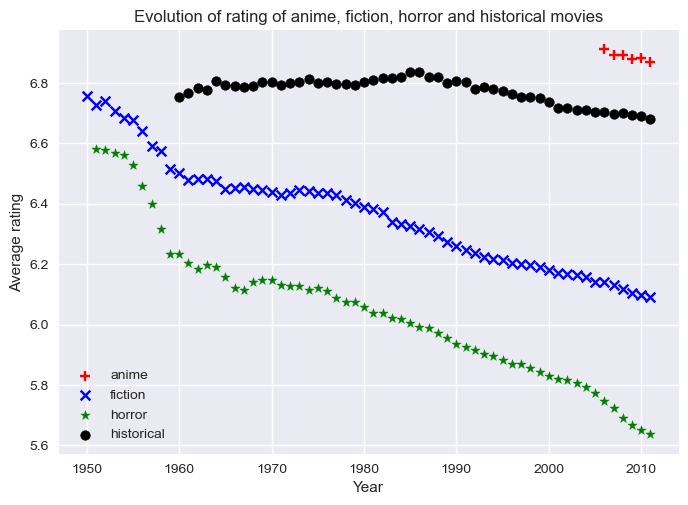

In [15]:
# Plot evolution of rating for some genres
for year in range(1950, 2012):
    if year not in genre_rates_by_year:
        continue
    if "anime" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["anime"][0], color="red", label="anime" if year == 2011 else None, marker="+")
    if "fiction" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["fiction"][0], color="blue", label="fiction" if year == 2011 else None, marker="x")
    if "horror" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["horror"][0], color="green", label="horror" if year == 2011 else None, marker="*")
    if "historical" in genre_rates_by_year[year]:
        plt.scatter(year, genre_rates_by_year[year]["historical"][0], color="black", label="historical" if year == 2011 else None, marker="o")

plt.title("Evolution of rating of anime, fiction, horror and historical movies")
plt.ylabel("Average rating")
plt.xlabel("Year")
plt.legend()
plt.show()

In [16]:
# Create an interactive plot of the evolution of rating with chosen genres
import json
from ipywidgets.embed import embed_data

# Take all the possible genres from all years
genres = set()
for year in genre_rates_by_year:
    genres.update(genre_rates_by_year[year].keys())

genres = list(genres)

widget = widgets.SelectMultiple(options=genres, value=genres, description="Genres:")
def plot_genre_evolution(genres):
    genre_rates = dict()
    for genre in genres:
        rates = []
        for year in range(1950, 2012):
            if year not in genre_rates_by_year:
                continue
            if genre in genre_rates_by_year[year]:
                rate = genre_rates_by_year[year][genre][0]
                rates.append((year, rate))
        # Plot the rate as a function of the year for the genre
        plt.plot([x[0] for x in rates], [x[1] for x in rates], label=genre)
        genre_rates[genre] = rates
    
    # # Save the data to json
    # with open("genre_rates.json", "w") as f:
    #     json.dump(genre_rates, f)

    # plt.title("Evolution of rating of chosen genres")
    # plt.ylabel("Average rating")
    # plt.xlabel("Year")
    # plt.legend()
    # plt.show()

widgets.interact(plot_genre_evolution, genres=widget)

interactive(children=(SelectMultiple(description='Genres:', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.plot_genre_evolution(genres)>

In this plot we can see the decline of fiction and horror movies. They were the moreliked movies in the middle of the 20th century. But in the last 50 years they became less popular, entering the bottom 10 of the most popular genres.

On the other hand we can see the rise of historical movies. They were not popular before the 80s but they became more and more popular in the last 50 years.

And at last, we see the very recent rise of anime movies. They were almost inexistant before the 2000s but they became very popular in the last 10 years and the most popular in 2011.

#### Common features of worst rated movies

In this section we try to find some common features of the worst rated movies. First, we split the movies into 3 categories: the worst rated movies, the best rated movies and the movies in the middle. Then we compare the features of the 3 categories.

##### Split

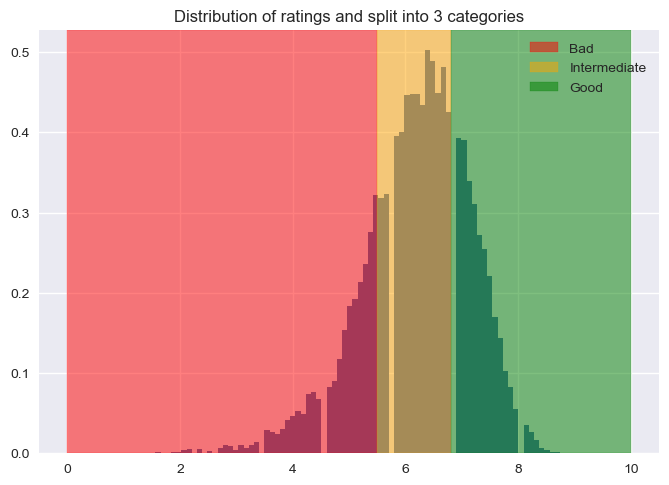

In [17]:
# Distribution of ratings
plt.hist(df_movies["vote_average"], bins=100, density=True)
# split into 3 categories
plt.axvspan(0, 5.5, alpha=0.5, color='red', label="Bad")
plt.axvspan(5.5, 6.8, alpha=0.5, color='orange', label="Intermediate")
plt.axvspan(6.8, 10, alpha=0.5, color='green', label="Good")
plt.legend()
plt.title("Distribution of ratings and split into 3 categories")
plt.show()

In [18]:
# Split the data into 3 groups
df_movies["rating_group"] = pd.cut(df_movies["vote_average"], bins=[0, 5.5, 6.8, 10], labels=["bad", "average", "good"])

# Print the number of movies in each group
df_movies["rating_group"].value_counts()

average    7821
good       3980
bad        3488
Name: rating_group, dtype: int64

##### Budget

What is the distribution of the budget in each category?

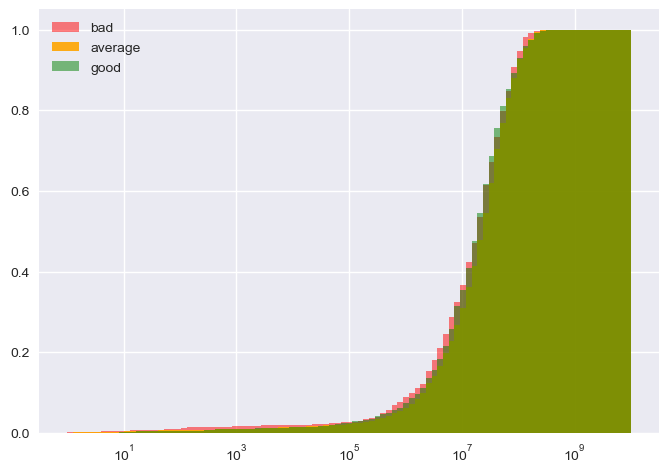

In [19]:
# Plot budget distribution by rating group
# Log binning
bins = np.logspace(0, 10, 100)
plt.hist(df_movies[df_movies["rating_group"] == "bad"]["adj_budget"], bins=bins, density=True, cumulative=True, label="bad", alpha=0.5, color="red")
plt.hist(df_movies[df_movies["rating_group"] == "average"]["adj_budget"], bins=bins, density=True, cumulative=True, label="average", alpha=0.9, color="orange")
plt.hist(df_movies[df_movies["rating_group"] == "good"]["adj_budget"], bins=bins, density=True,  cumulative=True,label="good", alpha=0.5, color="green")
# plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


While average and good moovies seems to have a similar distribution of budget, the worst movies have a lower budget. Let's confirm that with a t-test. 

In [20]:
ttest_results = ttest_ind(df_movies[df_movies["rating_group"] == "bad"]["adj_budget"].dropna(), df_movies[df_movies["rating_group"].isin(["good", "average"])]["adj_budget"].dropna())
print(f"Average budget for bad movies: {df_movies[df_movies['rating_group'] == 'bad']['adj_budget'].dropna().mean()}")
print(f"Average budget for other movies: {df_movies[df_movies['rating_group'].isin(['average', 'good'])]['adj_budget'].dropna().mean()}")
print("We can reject the null hypothesis that the average budget for bad movies is the same as for other movies with a p-value of", ttest_results.pvalue)

Average budget for bad movies: 13210338.759096626
Average budget for other movies: 14859176.826403113
We can reject the null hypothesis that the average budget for bad movies is the same as for other movies with a p-value of 0.015338871767646565


##### Revenue

Intuitively, we expect the worst movies to have a lower revenue. Let's confirm that with a t-test.

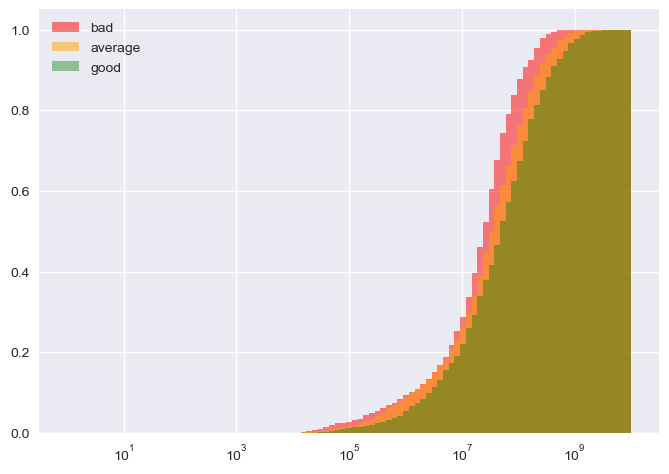

In [21]:
# Plot revenue distribution by rating group
# Log binning
bins = np.logspace(0, 10, 100)
plt.hist(df_movies[df_movies["rating_group"] == "bad"]["adj_revenue_x"], bins=bins, density=True, cumulative=True, label="bad", alpha=0.5, color="red")
plt.hist(df_movies[df_movies["rating_group"] == "average"]["adj_revenue_x"], bins=bins, density=True, cumulative=True, label="average", alpha=0.5, color="orange")
plt.hist(df_movies[df_movies["rating_group"] == "good"]["adj_revenue_x"], bins=bins, density=True,  cumulative=True,label="good", alpha=0.4, color="green")
# plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()


In [22]:
ttest_results = ttest_ind(df_movies[df_movies["rating_group"] == "bad"]["adj_revenue_x"].dropna(), df_movies[df_movies["rating_group"].isin(["good", "average"])]["adj_revenue_x"].dropna())
print(f"Average revenue for bad movies: {df_movies[df_movies['rating_group'] == 'bad']['adj_revenue_x'].dropna().mean()}")
print(f"Average revenue for other movies: {df_movies[df_movies['rating_group'].isin(['average', 'good'])]['adj_revenue_x'].dropna().mean()}")
print("We can reject the null hypothesis that the average revenue for bad movies is the same as for other movies with a p-value of", ttest_results.pvalue)

Average revenue for bad movies: 55864401.92924902
Average revenue for other movies: 127035473.21857497
We can reject the null hypothesis that the average revenue for bad movies is the same as for other movies with a p-value of 7.791177180984377e-18


#### The countries that have bad reviews

We would like to know where the worst movies are produced. Therefore we compute the average rating in each country and we represent the result in a map.

In [23]:
# Process the countries and languages columns
def process_countries_languages(x):
    if x is None or pd.isna(x):
        return []
    else:
        return list(json.loads(x).values())

df_movies["countries"] = df_movies["countries"].apply(process_countries_languages)
df_movies["languages"] = df_movies["languages"].apply(process_countries_languages)


In [24]:
# Another preprocessing step
countries_mapping = {
    "Palestinian territories": "Palestine",
    "Palestinian Territories": "Palestine",
    "West Germany": "Germany",
    "East Germany": "Germany",
    "Wales": "United Kingdom",
    "Korea": "South Korea",
    "Czechoslovakia": "Czech Republic",
    "Republic Democratic of the Congo": "Congo",
    "Kingdom of Great Britain": "United Kingdom",
    "Northern Ireland": "Ireland",
    "Republic of China": "China",
    "Slovak Republic": "Slovakia",
    "Georgian SSR": "Georgia",
    "Ukrainian SSR": "Ukraine",
    "German Democratic Republic": "Germany",
    "Kingdom of Italy": "Italy",
    "Mandatory Palestine": "Palestine"
}

def map_countries(x):
    return [x if x not in countries_mapping else countries_mapping[x] for x in x]

df_movies["countries"] = df_movies["countries"].apply(map_countries)

In [25]:
# Get all countries
all_countries = set()

for c in df_movies["countries"]:
    all_countries.update(c)

print("We have in total", len(all_countries), "different countries")
print(sorted(list(all_countries)))

We have in total 108 different countries
['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Bangladesh', 'Belgium', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon', 'Canada', 'Chile', 'China', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba', 'Czech Republic', 'Denmark', 'Egypt', 'England', 'Estonia', 'Federal Republic of Yugoslavia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Kenya', 'Kuwait', 'Lebanon', 'Libya', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mali', 'Malta', 'Mexico', 'Monaco', 'Mongolia', 'Montenegro', 'Morocco', 'Nazi Germany', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Pakistan', 'Palestine', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Republic of Macedonia', 'Romania', 'Russia', 'Scotland', '

In [26]:
# Create a column for each country, language
for c in all_countries:
    df_movies[f"played_in_{c}"] = df_movies["countries"].apply(lambda x: c in x)

In [27]:
# Average rating by country
country_rates = dict()
for c in all_countries:
    c_rates = df_movies[df_movies[f"played_in_{c}"]]["vote_average"]
    if len(c_rates) < 10 or c_rates.mean() < 1:
        continue
    country_rates[c] = c_rates

min_rating = min([country_rates[c].mean() for c in country_rates])
max_rating = max([country_rates[c].mean() for c in country_rates])

# Normalize the ratings
normalized_country_rates = dict()
for c in country_rates:
    normalized_country_rates[c] = (country_rates[c].mean() - min_rating) / (max_rating - min_rating)



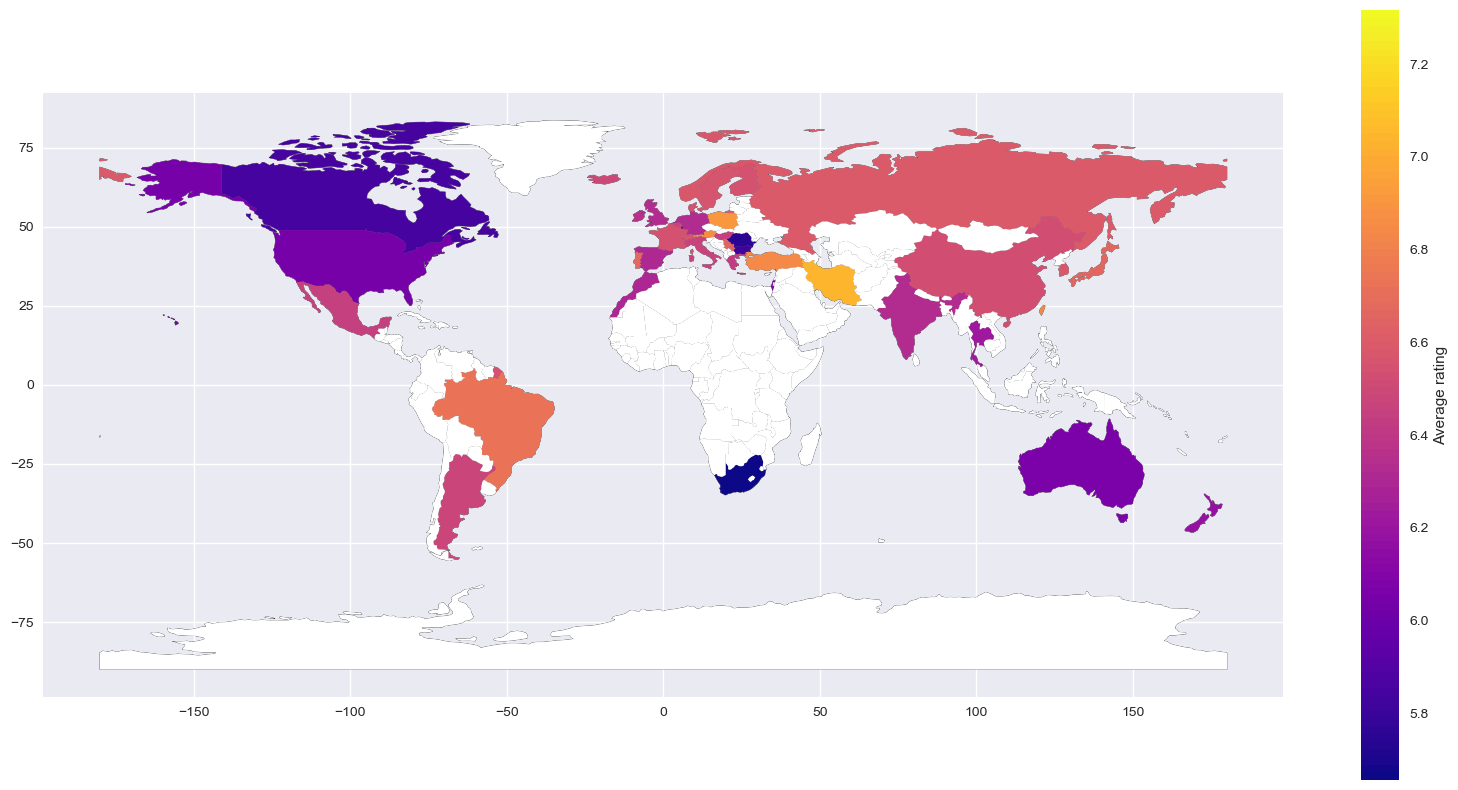

In [28]:
# World map coloured by vote average
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(20, 10), color="white", edgecolor="black")

cmap = matplotlib.colormaps["plasma"].resampled(100)

for c in normalized_country_rates:
    c_rate = normalized_country_rates[c]
    if c not in world.name.values:
        continue
    world[world.name == c].plot(color=cmap(c_rate),ax=ax)
for c in world.name.values:
    if c not in normalized_country_rates:
        world[world.name == c].plot(color="white",ax=ax)
# plt.set_cmap("plasma")
plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(min_rating, max_rating), cmap=cmap),
             ax=ax, label="Average rating")
plt.show()

Same thing but with group by region.

In [29]:
continent_mapping = {
    "Europe": {"France",  # <3
               "Spain",  # <3
               "Finland",  # <3
               "Albania", "Aruba", "Austria", "Belgium", "Bosnia and Herzegovnia", "Bulgaria", "Croatia", "Czech Republic", "Denmark", "England", "Estonia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Italy", "Latvia", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "Norway", "Poland", "Portugal", "Romania", "Russia", "Scotland", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "United Kingdom", "Vatican City", "Federal Rrepublic of Yugoslavia", "Yugoslavia", "Republic of Macedonia", "Soviet Union", "Bosnia and Herzegovina", "Nazi Germany", "Socialist Federal Republic of Yugoslavia", "Isle of Man", "Weimar Republic", "Federal Republic of Yugoslavia", "Serbia and Montenegro", "German Language"},
    "North America": {"Bahamas", "Barbados", "Belize", "Canada", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "El Salvador", "Grenada", "Guatemala", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Trinidad and Tobago", "United States of America", "United States Virgin Islands", "United States", "Puerto Rico"},
    "Middle East": {"Cyprus", "Egypt", "Iran", "Israel", "Kuwait", "Lebanon", "Oman", "Qatar", "Saudi Arabia", "Syria", "Turkey", "United Arab Emirates", "Yemen", "Palestine"},
    "Asia": {"Afghanistan", "Armenia", "Azerbaijan", "Bangladesh", "Bhutan", "Cambodia", "China", "Georgia", "India", "Indonesia", "Iraq", "Japan", "Hong Kong", "Jordan", "Malaysia", "Mongolia", "Pakistan", "Philippines", "Singapore", "South Korea", "Sri Lanka", "Taiwan", "Thailand", "Vietnam",  # <3
             "Uzbekistan"},
    "South America": {"Argentina", "Bolivia", "Brazil", "Chile", "Colombia", "Ecuador", "Guyana", "Paraguay", "Peru", "Suriname", "Uruguay", "Venezuela"},
    "Oceania": {"Australia", "Fiji", "New Zealand", "Papua New Guinea", "Samoa", "Solomon Islands", "Tonga", "Vanuatu"},
    "Africa": {"Algeria", "Burkina Faso", "Cameroon", "Congo", "Democratic Republic of the Congo", "Egypt", "Ethiopia", "Ghana", "Guinea", "Kenya", "Liberia", "Libya", "Madagascar", "Mali", "Mauritania", "Morocco", "Niger", "Nigeria", "Rwanda", "Senegal", "Sierra Leone", "Somalia", "South Africa", "Sudan", "Tanzania", "Togo", "Tunisia", "Uganda", "Zambia", "Zimbabwe"},
}
inv_continent_mapping = dict()
for k, v in continent_mapping.items():
    for c in v:
        inv_continent_mapping[c] = k

# Create a column for each continent
for c in continent_mapping:
    df_movies[f"played_in_{c}"] = df_movies["countries"].apply(lambda x: any([c == inv_continent_mapping[y] for y in x]))

continent_mapping["Asia"].update(continent_mapping.pop("Middle East"))


In [30]:
# Average rating by continent
region_rates = dict()
for c in continent_mapping:
    for country in continent_mapping[c]:
        if country not in country_rates:
            continue
        if c not in region_rates:
            region_rates[c] = []
        region_rates[c].append(country_rates[country].mean())
for c in continent_mapping:
    region_rates[c] = np.mean(region_rates[c])

min_rating = min([region_rates[c] for c in continent_mapping])
max_rating = max([region_rates[c] for c in continent_mapping])

# Normalize the ratings
normalized_region_rates = dict()
for c in region_rates:
    normalized_region_rates[c] = (region_rates[c] - min_rating) / (max_rating - min_rating)


['Oceania' 'Africa' 'North America' 'Asia' 'South America' 'Europe'
 'Seven seas (open ocean)' 'Antarctica']


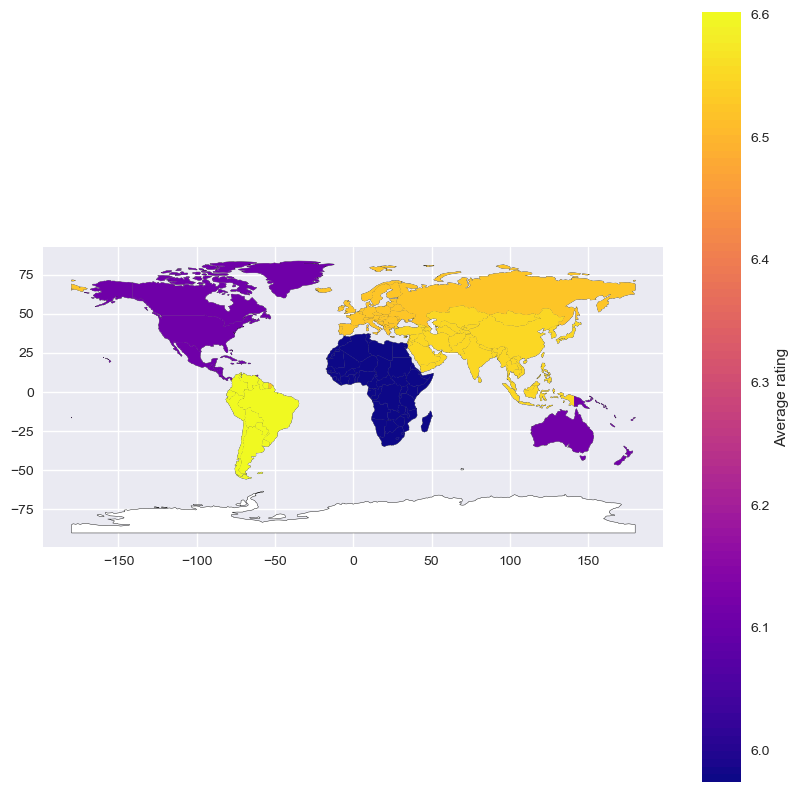

In [31]:
# World map coloured by vote average
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
print(world.continent.unique())
ax = world.plot(figsize=(10, 10), color="white", edgecolor="black")

for c in region_rates:
    r_rate = normalized_region_rates[c]
    if c not in world.continent.values:
        continue
    world[world.continent == c].plot(color=cmap(r_rate),ax=ax)
for c in world.continent.values:
    if c not in region_rates:
        continue
        world[world.name == c].plot(color="white",ax=ax)

plt.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(min_rating, max_rating), cmap=cmap),
             ax=ax, label="Average rating")
plt.show()

#### So can we predict the rating of a movie?

With all the features we have explored so far: budget, revenue, genre, country, we can try to predict the rating of a movie. With the one hot encoding of the genre and continent, we have 52 features.

Before attempting this, we filter out movies whose vote count is below 10. This is to filter out the noisy ratings because those are determined by very few users.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def get_data(features_name, target_name, drop_vote_count=9):
    all_features = features_name + [target_name]
    data = df_movies[all_features+["vote_count"]].copy()
    len_before = len(data)
    data = data[data["vote_count"] > drop_vote_count]
    print(f"Dropped {len_before - len(data)} movies with vote_count <= {drop_vote_count}")
    data = data.dropna()
    print(f"Total number of movies: {len(data)}")
    print(f"Number of features: {len(features_name)}")
    return data[features_name], data[target_name]


def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of test samples: {len(X_test)}")
    return X_train, X_test, y_train, y_test


def train_model(X_train, y_train):
    model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
    model.fit(X_train, y_train)
    return model


def train_linear_model(X_train, y_train):
    X_train = sm.add_constant(X_train)
    X_train = np.float32(X_train)
    model = sm.OLS(y_train, X_train, missing='drop')
    results = model.fit()
    return results


def evaluate_model(model, X_test, y_test):
    score = model.score(X_test, y_test)
    print(f"R squared: {score}")


In [33]:
features_name = ["year", "adj_budget", "runtime_x", "adj_revenue_x"] + [f"played_in_{c}" for c in continent_mapping] + [f"is_{g}" for g in all_genres]
target_name = "vote_average"

X, y = get_data(features_name, target_name)
X_train, X_test, y_train, y_test = split_data(X, y)
basic_model = train_model(X_train, y_train)
evaluate_model(basic_model, X_test, y_test)
mse_1 = (y_test - basic_model.predict(X_test)) ** 2

Dropped 0 movies with vote_count <= 9
Total number of movies: 5968
Number of features: 52
Number of training samples: 4774
Number of test samples: 1194
R squared: 0.3695355241175833


So we got a $R^2$ of 0.370 of the test set that is not really high. If we want to explain the rating of a movie, we should find more features.

### Binary Classification

The next thing we could try is to convert the prediction task into classification. The target here is whether the rating of a movie is less than 5.5, which is the threshold for bad movies given above.

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
import sklearn.utils

In [35]:
def split_data_2(X, y):
    # X, y = upsample_minority(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of test samples: {len(X_test)}")
    return X_train, X_test, y_train, y_test


def upsample_minority(X, y, minor_label=1, downsample=False):
    np.random.seed(42)
    major_label = 1 - minor_label
    (indices_major,) = np.where(y == major_label)
    (indices_minor,) = np.where(y == minor_label)
    indices_minor_upsampled = sklearn.utils.resample(
        indices_minor,
        replace=not downsample,
        n_samples=len(indices_major),
        random_state=42
    )
    indices = np.random.permutation(np.concatenate((indices_major, indices_minor_upsampled)))
    return X.iloc[indices], y.iloc[indices]


def train_and_evaluate(df, features_name, target_name):
    X, y = get_data_2(df, features_name, target_name)
    y = (y < 5.5).astype(int)
    print(f"Proportion of movies with ratings lower than 5.5: {np.round(y.sum()/len(y)*100)}%")
    X_train, X_test, y_train, y_test = split_data_2(X, y)
    X_train, y_train = upsample_minority(X_train, y_train, 1, False)
    clf = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=42)
    # clf = ComplementNB()
    clf = clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:,1]
    y_pred = clf.predict(X_test)
    auroc = metrics.roc_auc_score(y_test, y_score)
    f1 = metrics.f1_score(y_test, y_pred)
    rep = metrics.classification_report(y_test, y_pred)
    print("---------")
    print("AUROC", auroc)
    print("f1-score", f1)
    print(rep)
    return clf


def get_feature_importances(random_forest_clf):
    feature_importances = {}
    for i, feat in enumerate(features_name):
        feature_importances[feat] = random_forest_clf.feature_importances_[i]
    feature_importances = sorted(feature_importances.items(), key=lambda x:x[1], reverse=True)
    return feature_importances


def get_data_2(df, features_name, target_name, drop_vote_count=9):
    all_features = features_name + [target_name]
    data = df[all_features+["vote_count"]].copy()
    len_before = len(data)
    data = data[data["vote_count"] > drop_vote_count]
    print(f"Dropped {len_before - len(data)} movies with vote_count <= {drop_vote_count}")
    data = data.dropna()
    print(f"Total number of movies: {len(data)}")
    print(f"Number of features: {len(features_name)}")
    return data[features_name], data[target_name]

In [36]:
features_name = ["year", "adj_budget", "runtime_x", "adj_revenue_x"] + [f"played_in_{c}" for c in continent_mapping] + [f"is_{g}" for g in all_genres]
target_name = "vote_average"
clf = train_and_evaluate(df_movies, features_name, target_name)

Dropped 0 movies with vote_count <= 9
Total number of movies: 5968
Number of features: 52
Proportion of movies with ratings lower than 5.5: 18.0%
Number of training samples: 4177
Number of test samples: 1791
---------
AUROC 0.7984262828894644
f1-score 0.502883506343714
              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1468
           1       0.40      0.67      0.50       323

    accuracy                           0.76      1791
   macro avg       0.66      0.73      0.67      1791
weighted avg       0.82      0.76      0.78      1791



In [37]:
# sanity check our model: predict the rating for The Room (2003)
the_room = df_movies[df_movies["wiki_id"] == 5443971]
clf.predict(the_room[features_name].replace(np.nan, 0).values)

array([1])

If we consider the f1-score and the AUROC, the model is not that bad. Next, let's check which features are important.

In [38]:
get_feature_importances(clf)

[('runtime_x', 0.19400492945957903),
 ('adj_revenue_x', 0.16439540696550722),
 ('is_drama', 0.11369472972825663),
 ('year', 0.10430851523280689),
 ('adj_budget', 0.07274222385344109),
 ('played_in_North America', 0.025490707535578864),
 ('is_horror', 0.02246972789431863),
 ('is_adventure', 0.01963304031314855),
 ('is_comedy', 0.01783199229048468),
 ('is_action', 0.01771272473084908),
 ('is_indie', 0.015299247958550312),
 ('is_historical', 0.014513256609874011),
 ('is_documentary', 0.014496070914051832),
 ('is_old movies', 0.014421276325735302),
 ('played_in_Europe', 0.01367428574646758),
 ('is_thriller', 0.012020230932332414),
 ('is_family', 0.011071988423794298),
 ('is_romance', 0.010728230375365853),
 ('is_crime', 0.009998829773771988),
 ('is_fiction', 0.00973264972821548),
 ('is_world cinema', 0.008954599772906089),
 ('is_biographical film', 0.008191617748543361),
 ('is_animation', 0.007510301317987787),
 ('is_music', 0.0073836911216814865),
 ('is_war film', 0.0073325237206639145),


The higher this value, the more important a feature. It looks like the four numerical features runtime, revenue, year, budget are the most important ones. To confirm this, let's fit another model without those features. 

In [39]:
features_name = [f"played_in_{c}" for c in continent_mapping] + [f"is_{g}" for g in all_genres]
target_name = "vote_average"
clf = train_and_evaluate(df_movies, features_name, target_name)

Dropped 0 movies with vote_count <= 9
Total number of movies: 15290
Number of features: 48
Proportion of movies with ratings lower than 5.5: 20.0%
Number of training samples: 10703
Number of test samples: 4587
---------
AUROC 0.7575951763538136
f1-score 0.48040033361134277
              precision    recall  f1-score   support

           0       0.89      0.75      0.82      3676
           1       0.39      0.63      0.48       911

    accuracy                           0.73      4587
   macro avg       0.64      0.69      0.65      4587
weighted avg       0.79      0.73      0.75      4587



In [40]:
# sanity check our model: predict the rating for The Room (2003)
the_room = df_movies[df_movies["wiki_id"] == 5443971]
clf.predict(the_room[features_name].replace(np.nan, 0).values)

array([0])

### Feature extraction

#### Competition effect

It is intuitive to believe that the competition bewteen movies has an effect on the success or failure of a movie. But what is the competition?

The features related to competition we extract are :
 - the number of movies released the same week
 - the number of movies released the same month
 - the number of movies released the same year

 - the number of movies released the same week of the same genre
 - the number of movies released the same month of the same genre
 - the number of movies released the same year of the same genre

In [41]:
# Only keep movies with a release date
df_movies = df_movies.dropna(subset=["release_date"])

# Count the number of movies per week, month, year 
for period in ["W", "M", "Y"]:
    df_movies["period"] = df_movies["release_date"].apply(lambda x: x.to_period(period))
    mapping = df_movies.groupby("period")["period"].count().to_dict()
    df_movies["num_release_this_" + period] = df_movies["period"].apply(lambda x: mapping[x] if x in mapping else 0)
df_movies.drop(columns=["period"], inplace=True)

# Count the number of movies per week, month, year of the same genre
for period in ["W", "M", "Y"]:
    df_movies["num_release_this_" + period + "_of_same_genre"] = 0
    df_movies["period"] = df_movies["release_date"].apply(lambda x: x.to_period(period))
    for g in all_genres:
        df_movies.groupby("period")[f"is_{g}"].sum()
        mapping = df_movies.groupby("period")[f"is_{g}"].sum().to_dict()
        df_movies[f"num_release_this_{period}_of_same_genre"] += df_movies["period"].apply(lambda x: mapping[x] if x in mapping else 0)
df_movies.drop(columns=["period"], inplace=True)


Let's first see the correlation between each new feature and the rating.

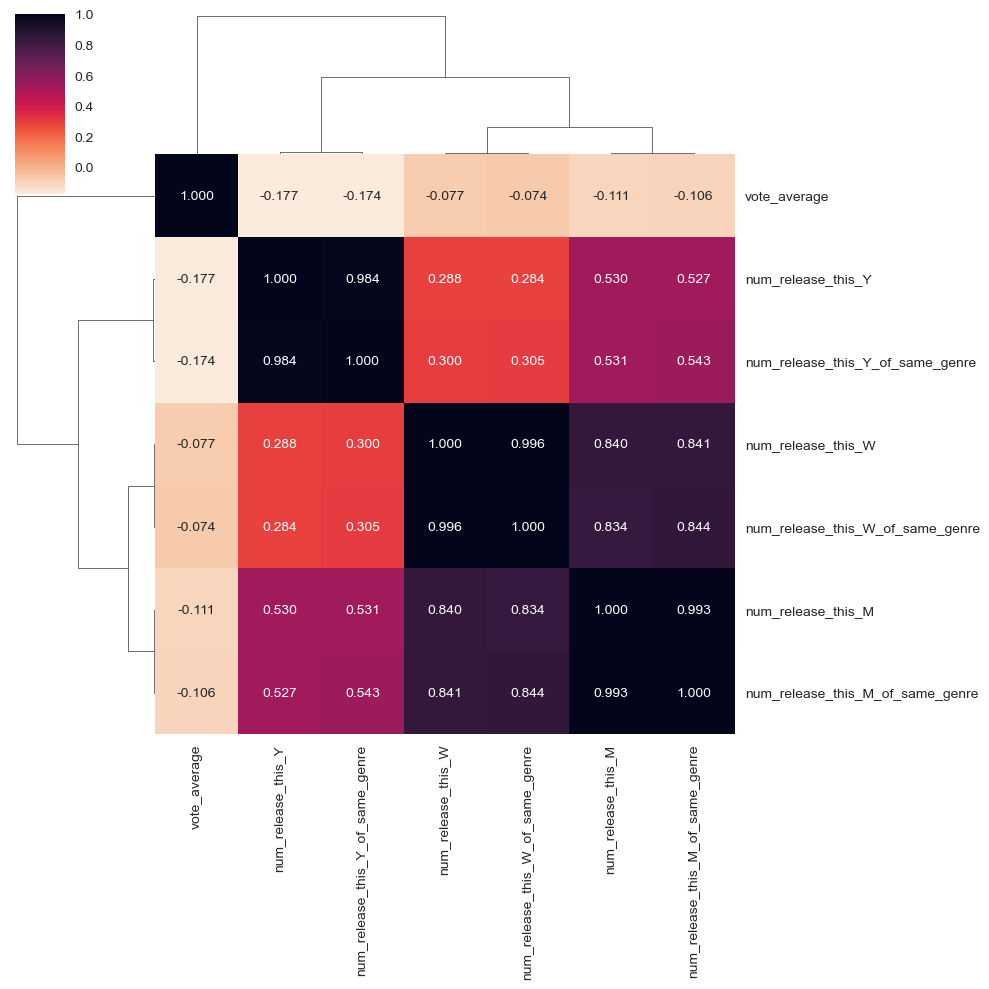

In [42]:
sns.clustermap(df_movies[["num_release_this_W", "num_release_this_M", "num_release_this_Y",
           "num_release_this_W_of_same_genre", "num_release_this_M_of_same_genre", "num_release_this_Y_of_same_genre",
           "vote_average"]].corr(), cmap="rocket_r", annot=True, fmt=".3f")

So we can see that grouping by genre is not really useful the values are very correlated with the non grouped values. We will only use the non grouped values.

Then we can see that the number of movies released the same week, month or year are not highly correlated with the rating. Nevertheless we can still note the negative correlation between the number of movies released the same week or month and the rating. On the contrary the number of movies released the same year is positively correlated with the rating. 


In [43]:
features_name = ["year", "adj_budget", "runtime_x", "adj_revenue_x"] + [f"played_in_{c}" for c in continent_mapping] + [f"is_{g}" for g in all_genres]
features_name += ["num_release_this_W", "num_release_this_M", "num_release_this_Y"]
target_name = "vote_average"

X, y = get_data(features_name, target_name)
X_train, X_test, y_train, y_test = split_data(X, y)
competition_model = train_model(X_train, y_train)
evaluate_model(competition_model, X_test, y_test)


Dropped 0 movies with vote_count <= 9
Total number of movies: 5968
Number of features: 55
Number of training samples: 4774
Number of test samples: 1194
R squared: 0.370209024450049


The regression model did not improve, with respect to the R2 score.

### Binary classification

In [44]:
features_name = ["year", "adj_budget", "runtime_x", "adj_revenue_x"] + [f"played_in_{c}" for c in continent_mapping] + [f"is_{g}" for g in all_genres]
features_name += ["num_release_this_W", "num_release_this_M", "num_release_this_Y"]
clf = train_and_evaluate(df_movies, features_name, target_name)

Dropped 0 movies with vote_count <= 9
Total number of movies: 5968
Number of features: 55
Proportion of movies with ratings lower than 5.5: 18.0%
Number of training samples: 4177
Number of test samples: 1791
---------
AUROC 0.798181641794822
f1-score 0.5174013921113689
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1468
           1       0.41      0.69      0.52       323

    accuracy                           0.77      1791
   macro avg       0.67      0.74      0.68      1791
weighted avg       0.83      0.77      0.79      1791



We barely improved the f1-score.

In [45]:
get_feature_importances(clf)

[('runtime_x', 0.16862441266270695),
 ('adj_revenue_x', 0.14092622140406189),
 ('is_drama', 0.10743519525448793),
 ('year', 0.07011786552362659),
 ('num_release_this_Y', 0.06169008334743701),
 ('adj_budget', 0.05881970717378448),
 ('num_release_this_M', 0.05851884102542772),
 ('num_release_this_W', 0.04269515001947935),
 ('played_in_North America', 0.023028749672099995),
 ('is_horror', 0.020987820921267702),
 ('is_adventure', 0.016944993183655634),
 ('is_action', 0.015244642593843538),
 ('is_comedy', 0.014552286398711013),
 ('is_indie', 0.013756194937798128),
 ('is_historical', 0.013343888182420618),
 ('is_documentary', 0.012553331621356785),
 ('played_in_Europe', 0.010806189617973909),
 ('is_family', 0.009757499653632488),
 ('is_thriller', 0.00961087281479748),
 ('is_romance', 0.008863857266495778),
 ('is_crime', 0.008087125729051818),
 ('is_old movies', 0.007881036573097917),
 ('is_fiction', 0.007837663070103223),
 ('is_biographical film', 0.007093087912773287),
 ('is_world cinema', 

We can see that these new features are indeed more helpful than the previous features.

In [46]:
# sanity check our model: predict the rating for The Room (2003)
the_room = df_movies[df_movies["wiki_id"] == 5443971]
clf.predict(the_room[features_name].replace(np.nan, 0).values)

array([1])

### Initial analysis of keywords

In Milestone P2, we proposed using tvtropes' list of tropes to analyze whether tropes are relevant to the movies. However, there are few movies in the dataset that have trope information.

Instead, what we could do is to analyze the keywords of the movies as almost all movies in our dataset have keywords. This could replace both the trope analysis as well as the analysis of plot summaries since keywords are, in some sense, condensed version of the plot summaries.

In [47]:
import ast
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import os
import pyLDAvis
import pyLDAvis.gensim_models

c:\Users\towab\miniconda3\envs\ada\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [48]:
df_keywords = pd.read_csv("../data/Imdb/keywords.csv")
df_movies["id"] = df_movies["id"].astype(int)
df_keywords = df_keywords.merge(df_movies, on=["id"])

In [49]:
def extract_keyword_list(list_of_keyword_dicts):
    list_of_keyword_dicts = ast.literal_eval(list_of_keyword_dicts)
    keyword_list = []
    for keyword_dict in list_of_keyword_dicts:
        keyword = keyword_dict["name"].replace(' ', '')
        keyword_list.append(keyword)
    keyword_list = list(np.unique(keyword_list))
    return keyword_list

In [50]:
df_keywords["keywords"] = df_keywords["keywords"].apply(extract_keyword_list)
df_keywords = df_keywords[df_keywords["keywords"].apply(len) > 2] # drop movies less than 3 keywords
df_keywords = df_keywords.reset_index(drop=True)

First, since there are a lot of keywords in the dataset, we would like to cluster them into topics. This could be achieved by considering the list of keywords for each movie as a document, and then use Latent Dirichlet Allocation for topic modeling.

In [51]:
docs = df_keywords["keywords"].to_list()
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.5
min_wordcount = 5
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique keywords: %d' % len(dictionary))
print('Number of movies: %d' % len(corpus))

Number of unique keywords: 3389
Number of movies: 10128


In [52]:
params = {'passes': 20, 'random_state': 218}
base_models = dict()
lda = LdaMulticore(
    corpus=corpus, num_topics=20, id2word=dictionary, workers=os.cpu_count(),
    passes=params['passes'], random_state=params['random_state'], per_word_topics=True
)

In [53]:
# plot topics
data =  pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(data, "topic_modeling.html")
pyLDAvis.display(data)

Next, the natural question is whether we can use the most probable topic of a movie to predict its rating.

To find out, we should conduct preliminary analysis. Let's visualize the distribution of ratings within each keyword topic.

In [54]:
def get_main_topic_docs(ldamodel, corpus, texts):
    topic_ids, props, topic_keywords_list = [], [], []
    for i, row in enumerate(ldamodel[corpus]):
        topic_dist = row[0]
        i = np.argmax([p for topic_id, p in topic_dist])
        topic_id, prop = topic_dist[i]
        wp = ldamodel.show_topic(topic_id)
        topic_keywords = ", ".join([word for word, prop in wp])
        topic_ids.append(topic_id)
        props.append(prop)
        topic_keywords_list.append(topic_keywords)
    df = pd.DataFrame({
        "dominant_topic": topic_ids,
        "topic_perc_contrib": props,
        "topic_keywords": topic_keywords_list,
        "movie_keywords": texts
    })
    return df

df_topics = get_main_topic_docs(ldamodel=lda, corpus=corpus, texts=docs).reset_index(drop=True)
df_topics.head()

,dominant_topic,topic_perc_contrib,topic_keywords,movie_keywords
0,15,0.698423,"womandirector, independentfilm, duringcreditss...","[boy, boynextdoor, friends, friendship, jealou..."
1,5,0.841615,"musical, music, teacher, school, england, inde...","[basedonchildren'sbook, boardgame, disappearan..."
2,2,0.762485,"magic, aftercreditsstinger, duringcreditssting...","[bestfriend, duringcreditsstinger, fishing, ol..."
3,3,0.809983,"marriage, divorce, basedonnovel, independentfi...","[basedonnovel, chickflick, divorce, interracia..."
4,3,0.881243,"marriage, divorce, basedonnovel, independentfi...","[aging, baby, confidence, contraception, daugh..."


In [55]:
idx_max = df_topics.groupby('dominant_topic')["topic_perc_contrib"].idxmax()
df_topics.iloc[idx_max]

,dominant_topic,topic_perc_contrib,topic_keywords,movie_keywords
5669,0,0.947215,"kidnapping, revenge, hitman, assassin, lawyer,...","[bucharest, chase, chasesandraces, confined, c..."
9814,1,0.952495,"teenager, hospital, independentfilm, newlove, ...","[1910s, alcoholism, basedonplayormusical, clas..."
6175,2,0.952485,"magic, aftercreditsstinger, duringcreditssting...","[atlanticocean, attachmenttonature, emigrant, ..."
1647,3,0.956810,"marriage, divorce, basedonnovel, independentfi...","[anarchiccomedy, badluck, bathing, bestfriend,..."
2131,4,0.961996,"femalenudity, nudity, independentfilm, sex, sp...","[alien, ax, axemurder, brain, corpse, cultfilm..."
6088,5,0.949993,"musical, music, teacher, school, england, inde...","[adultery, alcoholic, backgroundsinger, blackp..."
9863,6,0.944107,"vampire, independentfilm, gay, womandirector, ...","[adultery, crossdressing, ecstasy, extramarita..."
3539,7,0.958692,"japan, dystopia, martialarts, future, samurai,...","[artificialintelligence, computer, computervir..."
7670,8,0.947210,"suspense, murder, mexico, revenge, filmnoir, a...","[basedonnovel, blackandwhite, boat, cafe, cont..."
8733,9,0.949987,"nudity, sex, alcohol, torture, jungle, indepen...","[aristocrat, blood, brother, cancer, contest, ..."


In [56]:
df_keywords["keyword_topic"] = df_topics["dominant_topic"]

We can see that they all look very similar to each other, and there is not much variance between them. Thus, it is not very likely that these topics are helpful for predicting movie ratings. Nevertheless, it does not hurt to try.

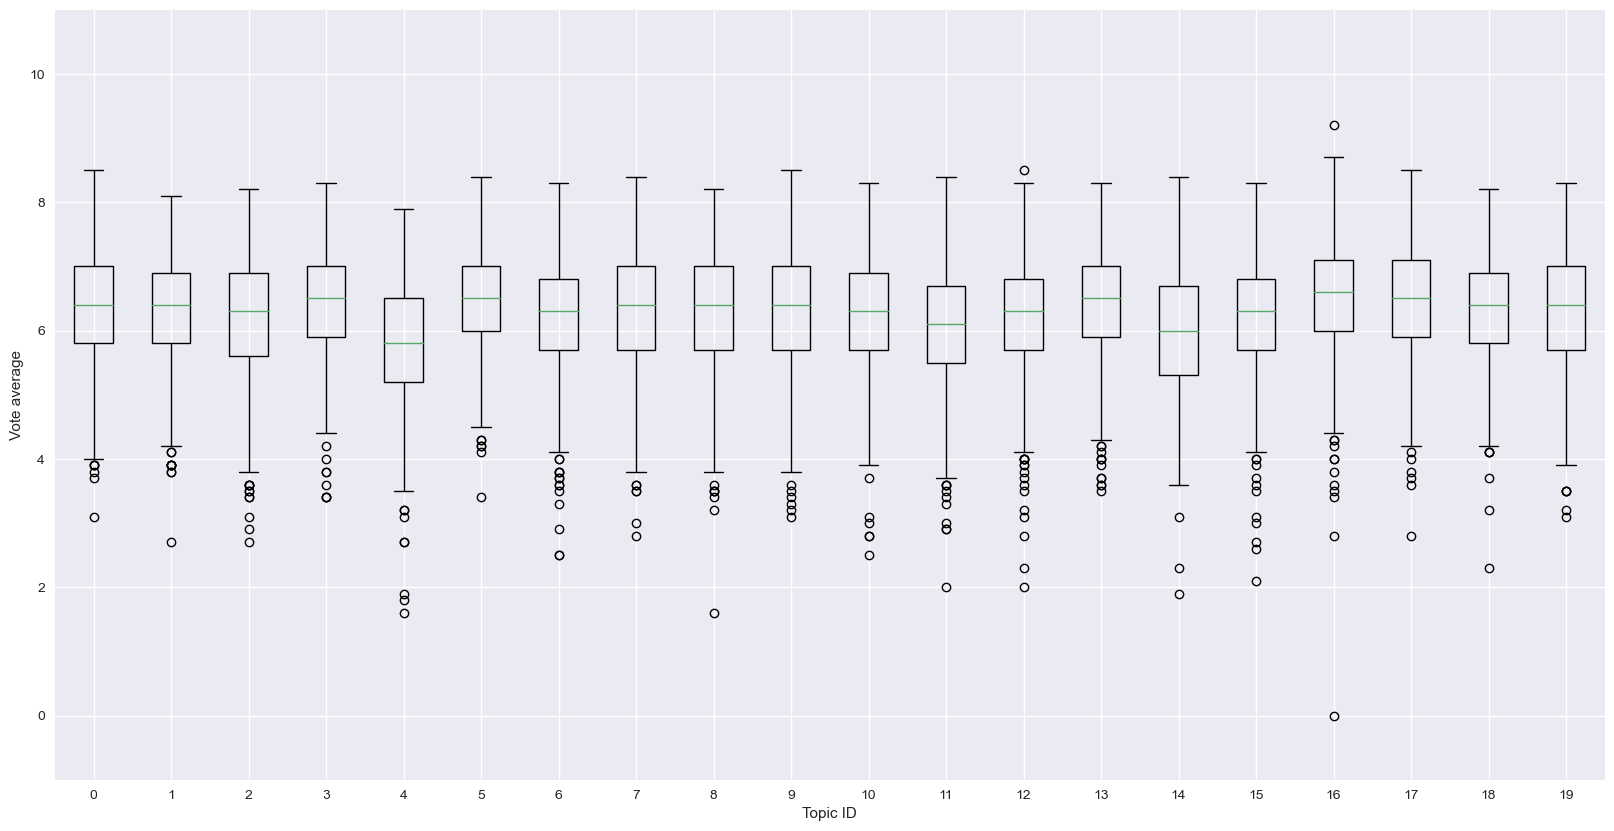

In [57]:
num_topics = len(df_keywords["keyword_topic"].unique())
for i in range(num_topics):
    df_keywords[f"keyword_topic_{i}"] = df_keywords["keyword_topic"].apply(lambda x: x == i)

vote_average_by_topic = []
for t in range(num_topics):
    vote_average_by_topic.append(df_keywords.loc[df_keywords["keyword_topic"]==t, "vote_average"].values)

plt.figure(figsize=(20, 10))
plt.boxplot(vote_average_by_topic)
plt.xticks(np.arange(num_topics)+1, np.arange(num_topics))
plt.ylim(-1, 11)
plt.xlabel("Topic ID")
plt.ylabel("Vote average")
plt.show()

In [58]:
features_name = ["year", "adj_budget", "runtime_x", "adj_revenue_x"] + \
    [f"played_in_{c}" for c in continent_mapping][:-1] + \
    [f"is_{g}" for g in all_genres][:-1] + \
    [f"keyword_topic_{i}" for i in range(num_topics)][:-1] + \
    ["num_release_this_W", "num_release_this_M", "num_release_this_Y"]
target_name = "vote_average"
clf = train_and_evaluate(df_keywords, features_name, target_name)

Dropped 0 movies with vote_count <= 9
Total number of movies: 4766
Number of features: 72
Proportion of movies with ratings lower than 5.5: 16.0%
Number of training samples: 3336
Number of test samples: 1430
---------
AUROC 0.8098740292234871
f1-score 0.5227655986509274
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1199
           1       0.43      0.67      0.52       231

    accuracy                           0.80      1430
   macro avg       0.68      0.75      0.70      1430
weighted avg       0.85      0.80      0.82      1430



In [59]:
get_feature_importances(clf)

[('runtime_x', 0.15471663180283207),
 ('adj_revenue_x', 0.12789586571212752),
 ('is_drama', 0.10559515126860437),
 ('year', 0.06500458737350329),
 ('num_release_this_Y', 0.05884394219699431),
 ('num_release_this_M', 0.055677106160468504),
 ('adj_budget', 0.05009979084398288),
 ('num_release_this_W', 0.041809516740824164),
 ('is_horror', 0.020681764166726804),
 ('is_comedy', 0.01847163105451535),
 ('played_in_North America', 0.015116372781511412),
 ('is_action', 0.0147517947228057),
 ('is_world cinema', 0.014723902404254934),
 ('is_historical', 0.014009860337475933),
 ('is_documentary', 0.013101430576517683),
 ('is_adventure', 0.011035238962173724),
 ('played_in_Europe', 0.0109630939300751),
 ('is_indie', 0.009992357913497629),
 ('keyword_topic_14', 0.008753353592193126),
 ('is_thriller', 0.00834463493053933),
 ('is_fiction', 0.00811880646112366),
 ('is_family', 0.007602063694871646),
 ('is_crime', 0.007363518305851541),
 ('keyword_topic_4', 0.0073079917413191265),
 ('is_animation', 0.0

It is clear from the feature importances that these new keyword topic features do not help at all. Thus, it is unlikely that keywords (the content of the plot summary and the tropes) play a big role in determining the rating of a movie. Although the topic modeling visualization was helpful for us to understand what sorts of movies are in the dataset, the keyword topics are not correlated to the ratings, and hence they are not useful for predicting the ratings.

Sanity checking our models with The Room (2003)

The Wiki ID of The Room is 5443971.

In [60]:
# sanity check our model: predict the rating for The Room (2003)
the_room = df_keywords[df_keywords["wiki_id"] == 5443971]
clf.predict(the_room[features_name].replace(np.nan, 0).values)

array([1])

In [61]:
the_room["keyword_topic"]

7475    5
Name: keyword_topic, dtype: int64

In [62]:
df_topics.iloc[the_room.index]["topic_keywords"].item()

'musical, music, teacher, school, england, independentfilm, singer, duringcreditsstinger, concert, murder'

In [63]:
" ".join(df_topics.iloc[the_room.index]["movie_keywords"].item())

'affair americanfootball cheatingfiancée drugpusher friends golddigger independentfilm relationships sliceoflife'

### What about actors


In [64]:
df_actors = get_characters()
df_actors = df_actors.merge(df_movies[["wiki_id", "vote_average"]], on="wiki_id") 
df_actors = df_actors[df_actors["vote_average"] > 0]

Let's see if the relationship between ratings and actors career i.e. the number of movies they have played in.

Text(0.5, 1.0, 'Number of movies actors played in vs. average rating of their movies')

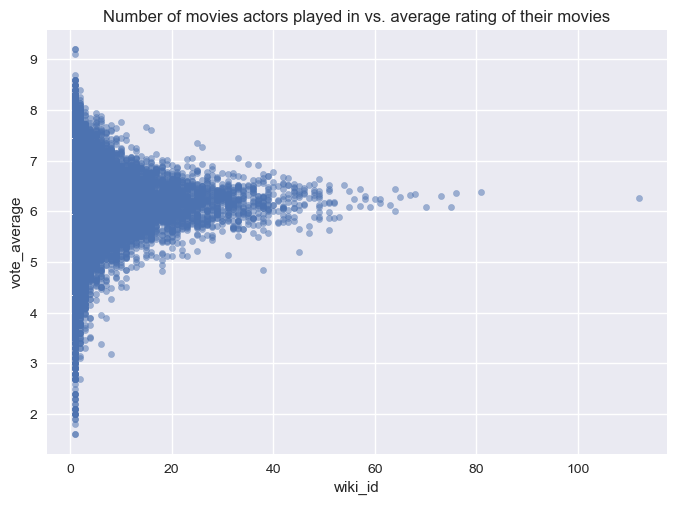

In [65]:
df_actors_grouped = df_actors.groupby(["actor_name", "actor_dob"])
df_actors_grouped = df_actors_grouped.agg({"vote_average": "mean", "wiki_id": "count"})
df_actors_grouped.plot(kind="scatter", x="wiki_id", y="vote_average", alpha=0.5)
plt.title("Number of movies actors played in vs. average rating of their movies")

With the previous plot, we can see that actors who have played mostly in very good movies or very bad movies, tend to end their career more quickly. But actors that have played in movies with a rating in the middle, tend to have a longer career.

Plotting the minimum rating of the movies they have played in, we can see that it is not rare for actors to have played in a movie with a very bad rating. Therefore it does not necessarily put an end to their career.

Text(0.5, 1.0, 'Number of movies actors played in vs. rating of their worst movies')

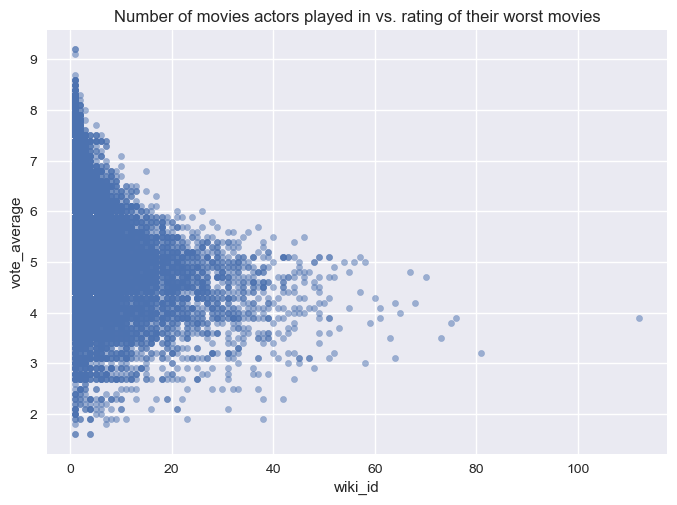

In [66]:
df_actors_grouped = df_actors.groupby(["actor_name", "actor_dob"])
df_actors_grouped = df_actors_grouped.agg({"vote_average": "min", "wiki_id": "count"})
df_actors_grouped.plot(kind="scatter", x="wiki_id", y="vote_average", alpha=0.5)
plt.title("Number of movies actors played in vs. rating of their worst movies")